In [1]:
import os
from pathlib import Path
from itertools import chain

import uproot
import awkward as ak
import numpy as np
import hist

import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep
%matplotlib inline
mpl.style.use(mplhep.style.ROOT)

from pyidm import load, mfsa, histogram

# Single-File Testing

In [7]:
signal_eg_fp = Path('/local/cms/user/eichl008/hps/idm/umn-signal/merged-with-Vc/nruns_200_nevents_10k_idm_2pt3_mchi_050_rmap_2.50_rdmchi_0.60_recon.root')

In [9]:
params, events = histogram.load(signal_eg_fp)

In [10]:
events

<Array [{fUniqueID: 0, fBits: ..., ...}, ...] type='4304 * {fUniqueID: uint...'>

In [175]:
n_vtx = ak.count(events.vertex.chi2, axis=1)
event_selections = {
    'multi_vertex' : n_vtx > 1,
    'one_vertex' : n_vtx==1,
    'no_vertex' : n_vtx==0,
}
n_trks = hist.Hist(
    hist.axis.StrCategory(
        list(event_selections.keys()),
        name='sl',
    ),
    hist.axis.Regular(
        5, 0, 5,
        name='n_ele_trks',
        label='Total Num Reco Electron Tracks'
    ),
    hist.axis.Regular(
        5, 0, 5,
        name='n_pos_trks',
        label='Total Num Reco Positron Tracks'
    ),
    hist.axis.Regular(
        3,-1.5,1.5,
        name='opp_pair_exists',
        label='$e^+e^-$ Pair of Tracks in Oppositive Halves Exists'
    )
)
for slname, sl in event_selections.items():
    electrons = events[sl].track[events[sl].track.charge < 0]
    positrons = events[sl].track[events[sl].track.charge > 0]
    epem_pairs = ak.cartesian({'electron':electrons,'positron':positrons})
    pair_exists = (ak.fill_none(
        ak.max(
            np.sign(epem_pairs.electron.tan_lambda*epem_pairs.positron.tan_lambda)*-1,
            axis=1
        ),
        -3
    )+1)/2
    print(len(electrons), len(electrons), len(pair_exists))
    n_trks.fill(
        sl=slname,
        n_ele_trks=ak.count(electrons.id, axis=1),
        n_pos_trks=ak.count(positrons.id, axis=1),
        opp_pair_exists = pair_exists
    )

0 0 0
2892 2892 2892
1412 1412 1412


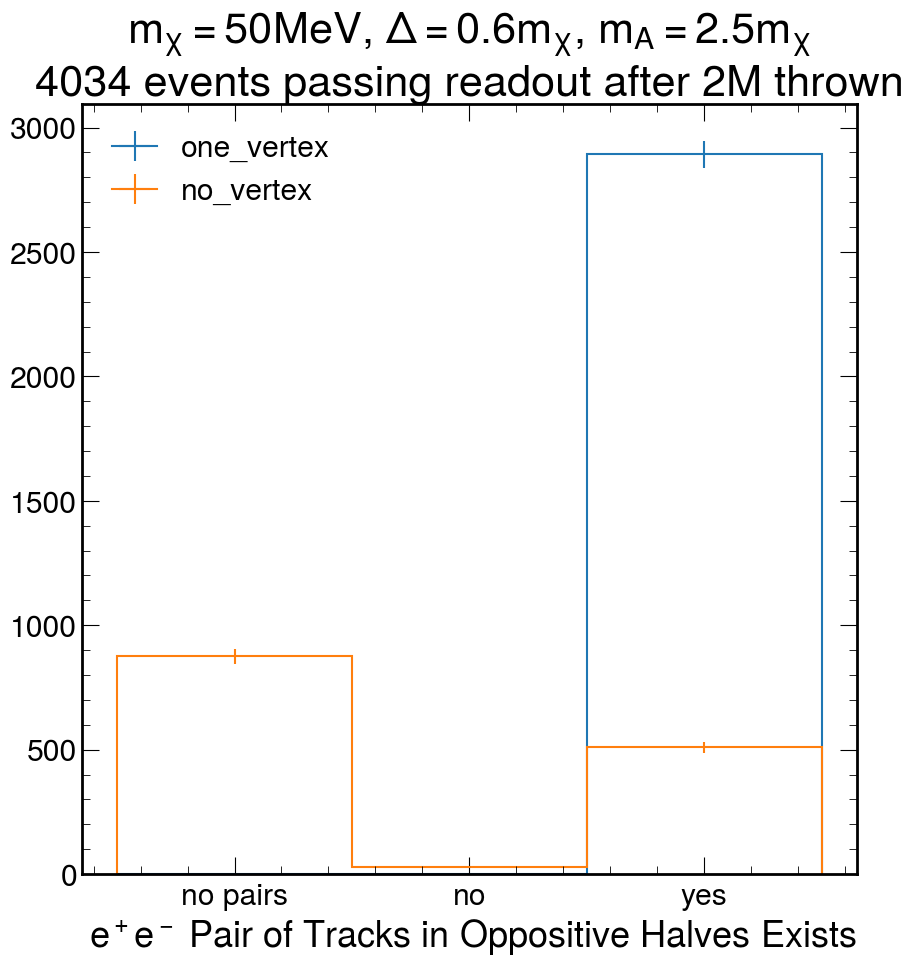

In [181]:
for s in ['one_vertex','no_vertex']:
    n_trks[s,sum,sum,:].plot(
        #density=True, 
        label=s
    )
plt.legend()
plt.xticks(
    [-1,0,1],
    ['no pairs','no','yes']
)
plt.title("""$m_\\chi=50$MeV, $\Delta=0.6m_\\chi$, $m_A=2.5m_\\chi$
4034 events passing readout after 2M thrown""")
plt.show()

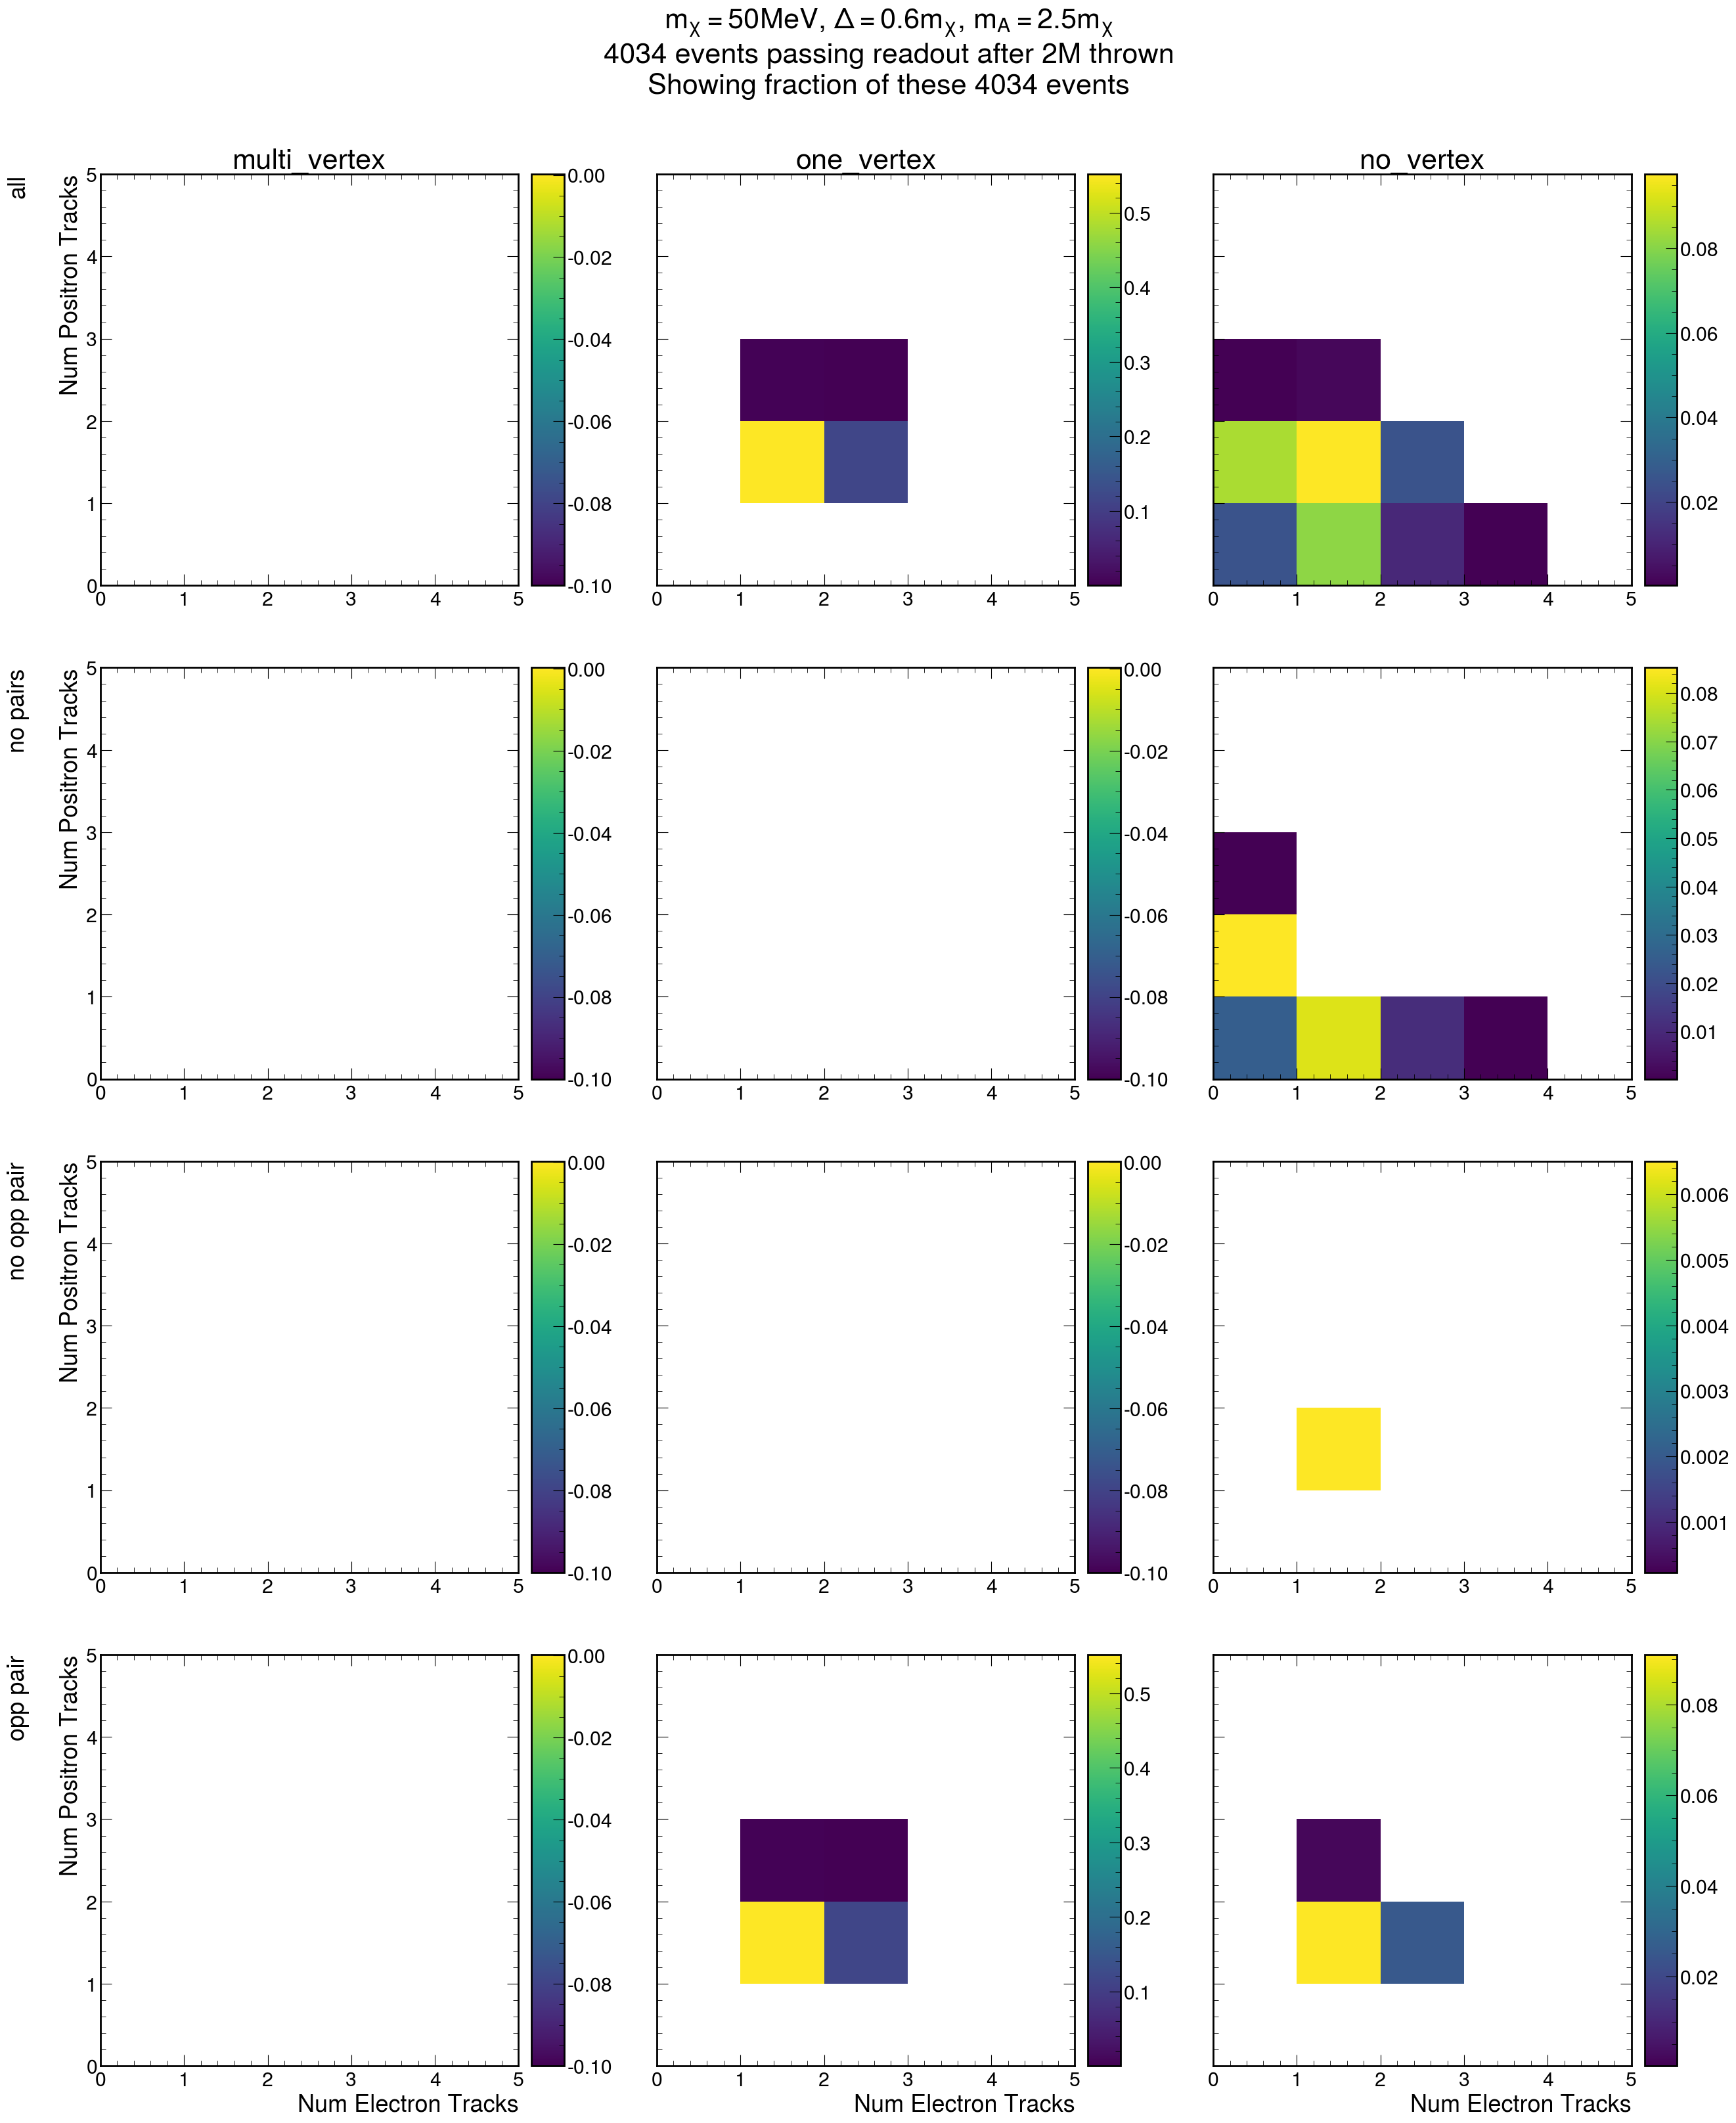

In [185]:
fig, axes = plt.subplots(
    nrows=4,
    ncols=3,
    figsize=(24,8*4),
    sharey='row',
    gridspec_kw=dict(
        top=0.9, bottom=0,
        left=0, right=1
    )
)

event_fraction = n_trks / n_trks.sum()

for icol, (s, col) in enumerate(zip(event_fraction.axes[0], axes.T)):
    for irow, (ax, pair_sl) in enumerate(zip(col, (sum, hist.loc(-1), hist.loc(0), hist.loc(1)))):
        event_fraction[s,:,:,pair_sl].plot2d(ax=ax, cmin=1/n_trks.sum())
        ax.set_xlabel('')
        ax.set_ylabel('')
    col[0].set_title(s)
    if icol==0:
        for row, rowtitle in zip(col, ['all','no pairs', 'no opp pair', 'opp pair']):
            row.set_ylabel('\n\n'.join([rowtitle,'Num Positron Tracks']))

for ax in axes[-1]:
    ax.set_xlabel('Num Electron Tracks')

fig.suptitle("""$m_\\chi=50$MeV, $\Delta=0.6m_\\chi$, $m_A=2.5m_\\chi$
4034 events passing readout after 2M thrown
Showing fraction of these 4034 events""")
for s, c in zip(event_fraction.axes[0], axes[0]):
    c.set_title(s)

plt.show()

In [200]:
print(np.unique(ak.flatten(events.track.charge)))
rec_ele = events.track[events.track.charge < 0]
rec_pos = events.track[events.track.charge > 0]
prod_mc_ele = events.mc_particle[(events.mc_particle.pdg==+11)&(events.mc_particle.momPDG==1023)]
prod_mc_pos = events.mc_particle[(events.mc_particle.pdg==-11)&(events.mc_particle.momPDG==1023)]

[-1, 1]


In [244]:
enough_tracks = (ak.count(electrons.id, axis=1)>1)&(ak.count(positrons.id, axis=1)>0)
rec_mc = ak.cartesian({'rec':rec_ele,'mc':prod_mc_ele})
rec_mc_ele_in_same_half = (ak.fill_none(
        ak.max(
            np.sign(rec_mc.rec.p.y*rec_mc.mc.p.y),
            axis=1
        ),
        -3
    )+1)/2
rec_mc_match = (
    (np.sign(rec_mc.rec.p.y*rec_mc.mc.p.y)==1) # same half
    &(abs(rec_mc.rec.p.mag-rec_mc.mc.p.mag)<0.1) # similar |p|
)
ak.sum(enough_tracks&ak.any(rec_mc_match,axis=1))

578

In [ ]:
plt.hist(
    ak.flatten(rec_mc.rec[enough_tracks&rec_mc_match].chi2),
    bins=100
)
plt.yscale('log')
plt.show()

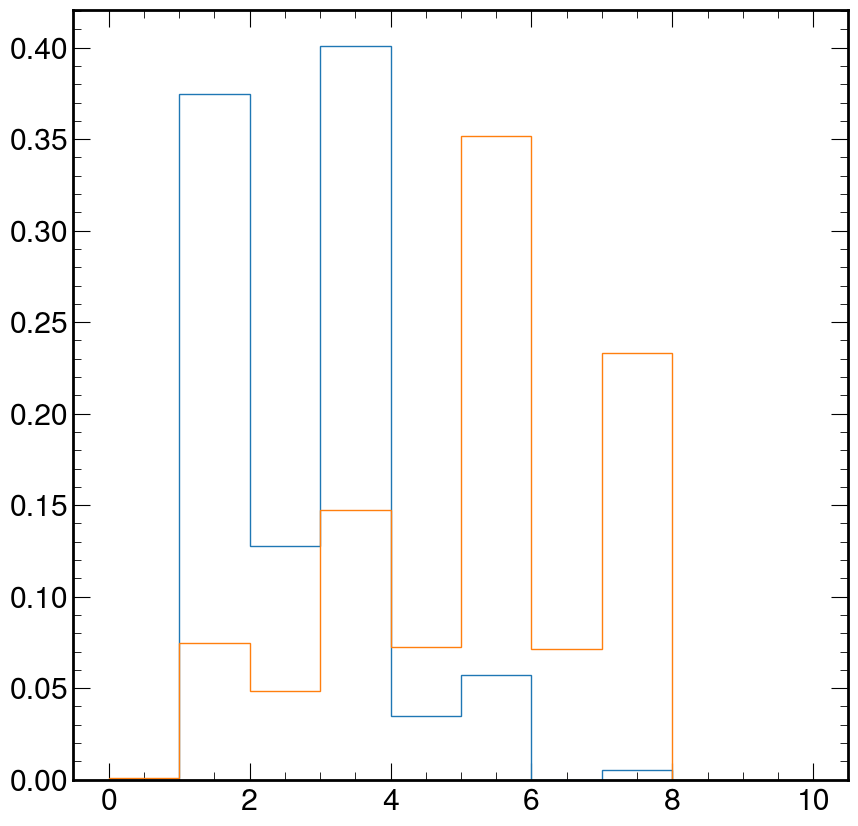

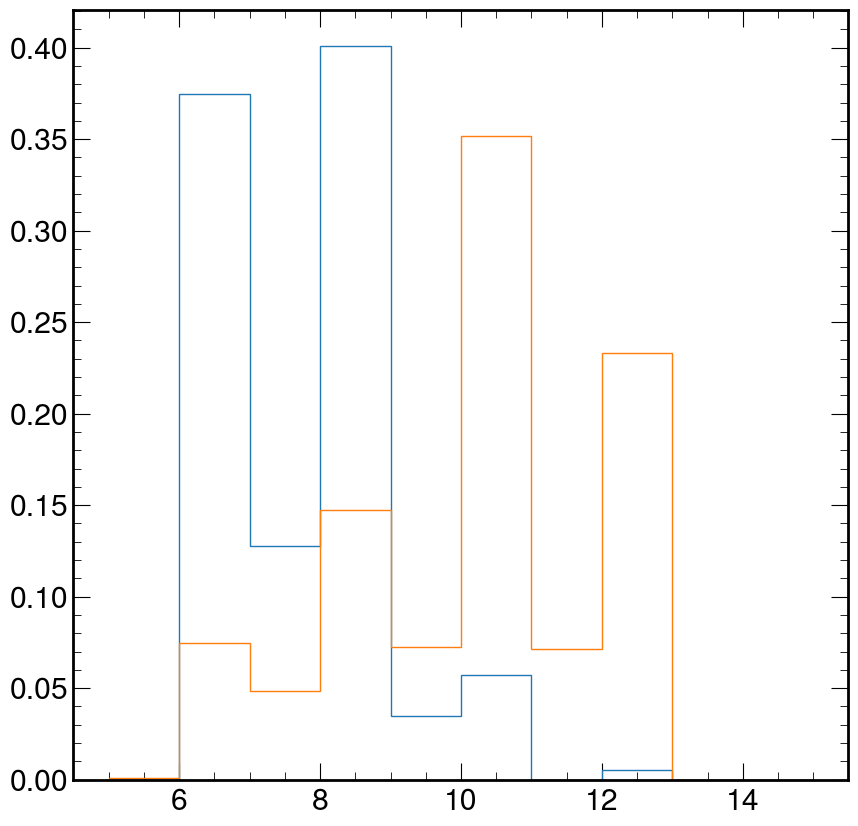

In [268]:
plt.hist(
    ak.flatten(rec_mc.rec[enough_tracks&rec_mc_match].ndf),
    range=(0,10),
    histtype='step',
    density=True
)
plt.hist(
    ak.flatten(rec_ele.ndf),
    range=(0,10),
    histtype='step',
    density=True
)
plt.show()

plt.hist(
    ak.flatten(rec_mc.rec[enough_tracks&rec_mc_match].n_hits),
    range=(5,15),
    histtype='step',
    density=True
)
plt.hist(
    ak.flatten(rec_ele.n_hits),
    range=(5,15),
    histtype='step',
    density=True
)
plt.show()

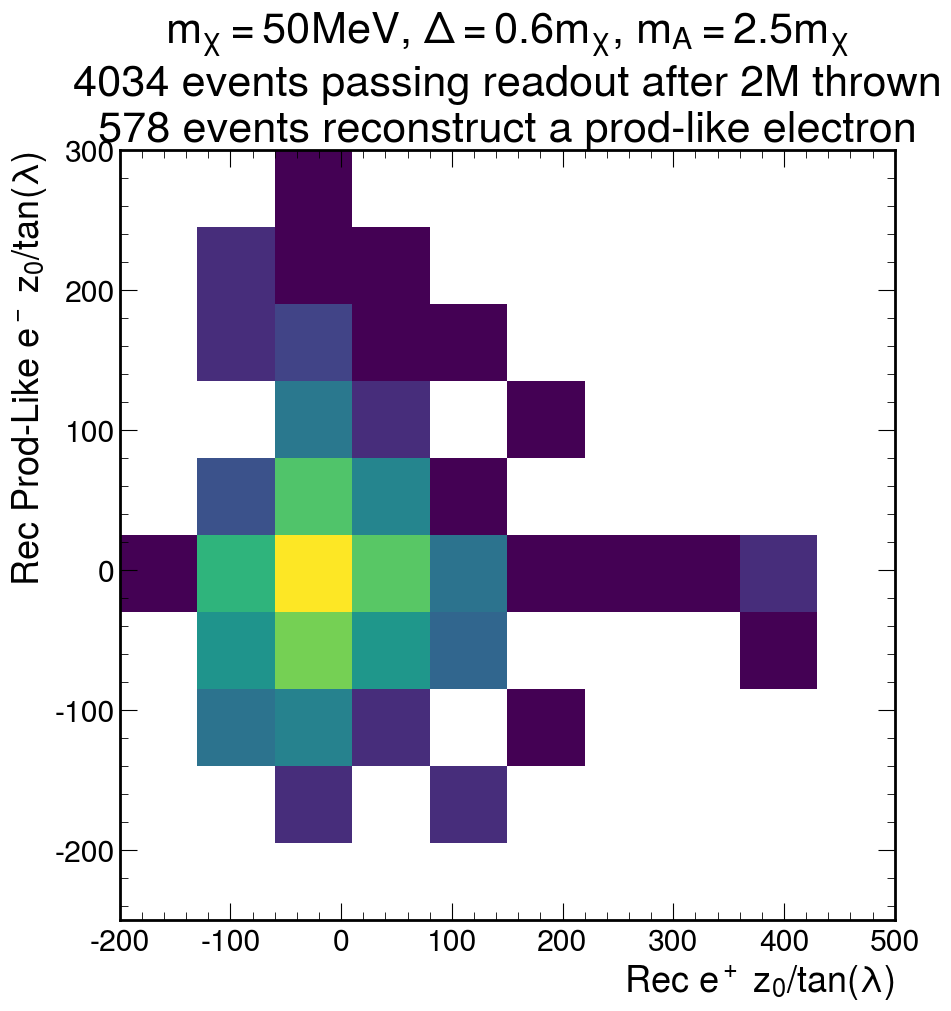

In [257]:
plt.hist2d(
    ak.flatten(rec_mc.rec[enough_tracks&rec_mc_match].z0/rec_mc.rec[enough_tracks&rec_mc_match].tan_lambda).to_numpy(),
    ak.flatten(rec_pos[enough_tracks&rec_mc_match].z0/rec_pos[enough_tracks&rec_mc_match].tan_lambda).to_numpy(),
    cmin=1,
    norm='log',
    bins=(10,10),
    range=((-200,500),(-250,300))
)
plt.title("""$m_\\chi=50$MeV, $\Delta=0.6m_\\chi$, $m_A=2.5m_\\chi$
4034 events passing readout after 2M thrown
578 events reconstruct a prod-like electron""")
plt.xlabel("Rec $e^+$ $z_0/\\tan(\\lambda)$")
plt.ylabel("Rec Prod-Like $e^-$ $z_0/\\tan(\\lambda)$")
plt.show()

In [192]:
f = uproot.open(signal_eg_fp)

In [208]:
f['HPS_Event/TrackerHits'].keys()

['TrackerHits.fUniqueID',
 'TrackerHits.fBits',
 'TrackerHits.x_',
 'TrackerHits.y_',
 'TrackerHits.z_',
 'TrackerHits.time_',
 'TrackerHits.layer_',
 'TrackerHits.module_',
 'TrackerHits.edep_',
 'TrackerHits.pdg_']

# Truth-Level Analysis
Look at sim-level file without any readout or reco filters applied

After readout+reco, the resulting number of events is O(0.1%) of the input generated number of events.

In [2]:
reco_events = load.FromROOT.hps_reco()('/local/cms/user/eichl008/hps/idm/signal/idm_2pt3_mchi_100_rmap_3.00_rdmchi_0.60_nruns_122_nevents_10k.root')

In [3]:
ak.sum(ak.count(reco_events.vertex.chi2, axis=1)==1)/122

9.647540983606557

In [4]:
events = load.FromROOT.hps_mc()('/local/cms/user/eichl008/hps/idm/signal/sim_idm_2pt3_mchi_100_rmap_3.00_rdmchi_0.60_nruns_1_nevents_10k.root')

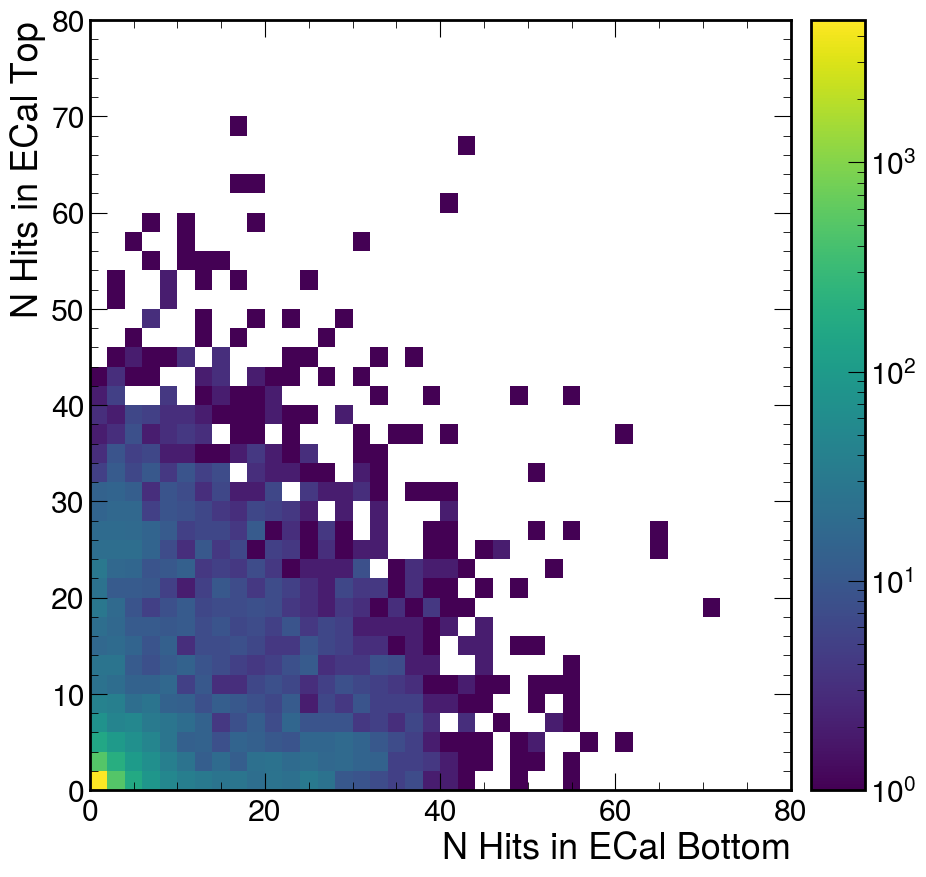

In [26]:
n_ecal_hits = hist.Hist(
    hist.axis.Regular(40,0,80,name='nbot',label='N Hits in ECal Bottom'),
    hist.axis.Regular(40,0,80,name='ntop',label='N Hits in ECal Top')
)
n_ecal_hits.fill(
    nbot = ak.count(events.mc_ecal_hits[events.mc_ecal_hits.iy < 0].iy, axis=1),
    ntop = ak.count(events.mc_ecal_hits[events.mc_ecal_hits.iy > 0].iy, axis=1)
)
n_ecal_hits.plot(
    cmin=1,
    norm='log'
)
plt.show()

In [5]:
top=(events.mc_ecal_hits.iy > 0)
bot=(events.mc_ecal_hits.iy < 0)
pos=(events.mc_ecal_hits.ix > 0)
ele=(events.mc_ecal_hits.ix < -10)

In [6]:
top_pos = ak.sum(events.mc_ecal_hits.energy[top&pos], axis=1)
top_ele = ak.sum(events.mc_ecal_hits.energy[top&ele], axis=1)
bot_pos = ak.sum(events.mc_ecal_hits.energy[bot&pos], axis=1)
bot_ele = ak.sum(events.mc_ecal_hits.energy[bot&ele], axis=1)
triggered = (
            (top_pos>0.150)&(bot_ele>0.150)&(top_pos+bot_ele>0.600)
        )|(
            (top_ele>0.150)&(bot_pos>0.150)&(top_ele+bot_pos>0.600)
        )

In [7]:
ak.sum(triggered)

42

In [47]:
top_hits = events.mc_ecal_hits[events.mc_ecal_hits.iy > 0]
bot_hits = events.mc_ecal_hits[events.mc_ecal_hits.iy < 0]

In [58]:
top_avg_ix = ak.sum(top_hits.energy*top_hits.ix, axis=1)/ak.sum(top_hits.energy, axis=1)
bot_avg_ix = ak.sum(bot_hits.energy*bot_hits.ix, axis=1)/ak.sum(bot_hits.energy, axis=1)
adiff_ix = abs(top_avg_ix - bot_avg_ix)

0

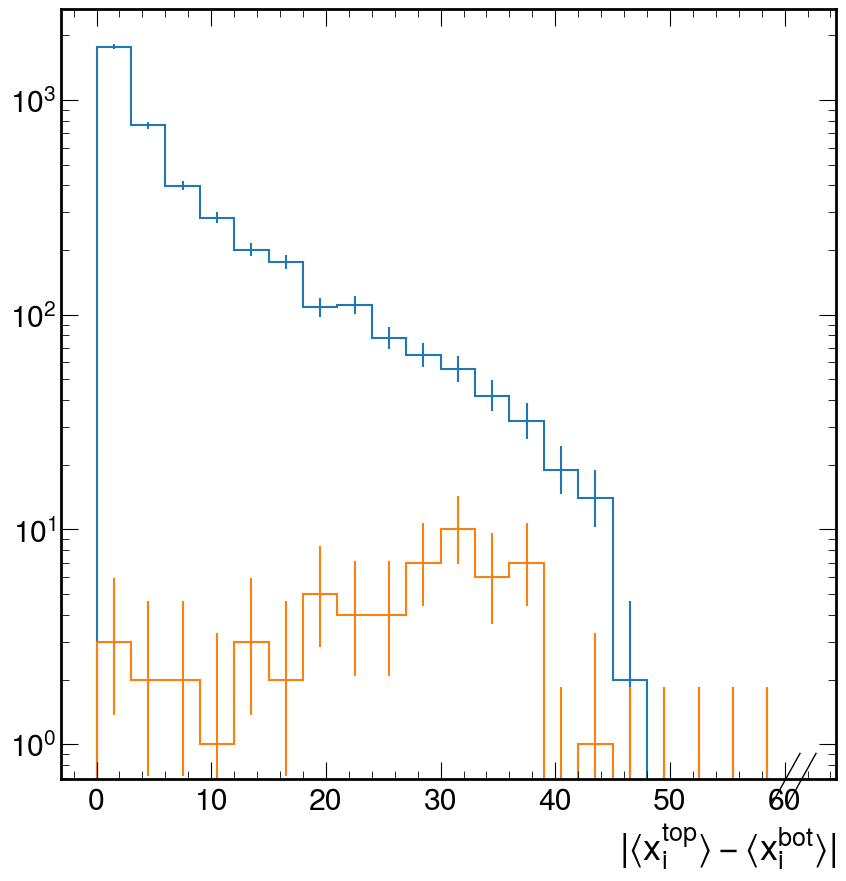

In [62]:
ix = hist.Hist(
    hist.axis.StrCategory(
        ['all','pass_energy'],
        name='category'
    ),
    hist.axis.Regular(
        20,0,60,
        name='adiff',
        label='$|\\langle x_{i}^{top} \\rangle - \\langle x_{i}^{bot} \\rangle|$'
    )
)
ix.fill(
    category='all',
    adiff = adiff_ix
)
ix.fill(
    category='pass_energy',
    adiff = adiff_ix[energy_only]
)
ix.plot()
plt.yscale('log')
plt.show()

In [13]:
hit_loc = hist.Hist(
    hist.axis.Regular(51,-25.5,25.5,name='ix',label='iX'),
    hist.axis.Regular(13,-6.5,6.5,name='iy',label='iY'),
).fill(
    ix = ak.flatten(events[triggered].mc_ecal_hits.ix),
    iy = ak.flatten(events[triggered].mc_ecal_hits.iy)
)

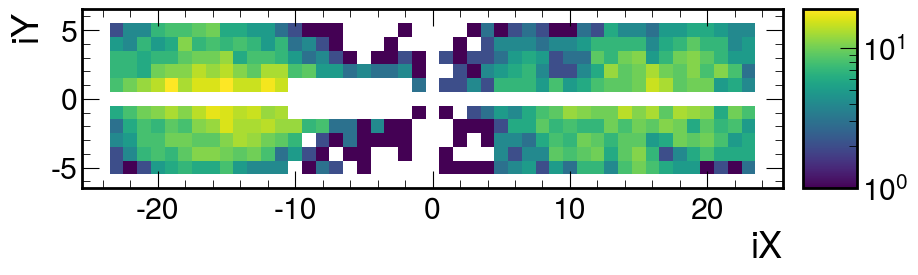

In [14]:
hit_loc.plot(cmin=1, norm='log')
plt.gca().set_aspect('equal')

# Single-File Analysis
First, let's start with a single file of each category.

In [2]:
wab_eg_fp = '/local/cms/user/eichl008/hps/idm/bkgd/wab/tuples/wab-beam_nruns_2000_startrun_1.root'
tritrig_eg_fp = '/local/cms/user/eichl008/hps/idm/bkgd/tritrig/tuples/tritrig-beam_nruns_200_startrun_1.root'
signal_eg_fp = '/local/cms/user/eichl008/hps/idm/signal/idm_2pt3_mchi_100_rmap_3.00_rdmchi_0.60_nruns_122_nevents_10k.root'

In [3]:
signal = load.FromROOT.hps()(signal_eg_fp)

# data = {
#     'signal' : load.FromROOT.hps()(signal_eg_fp),
#     'wab': load.FromROOT.hps()(wab_eg_fp),
#     'tritrig': load.FromROOT.hps()(signal_eg_fp)
# }

In [4]:
event_sel = (
    ak.count(signal.vertex.chi2, axis=1)==1 # exactly one vertex in event
)

In [5]:
# widths calculated from MG
mg_rate = 2.415e-14 # GeV - mchi=100MeV, delta=60MeV, map=300MeV
#mg_rate = 7.174e-15 # GeV - mchi=30MeV, delta=18MeV, map=90MeV

def ctau(rate):
    c = 3.00e10  # cm/s
    hbar = 6.58e-25  # GeV*sec
    return c*hbar/rate

def weight_by_z(z, gamma_c_tau):
    return np.exp((-4.3 - z)/gamma_c_tau)/gamma_c_tau

In [6]:
chi2 = ak.flatten(signal[event_sel].mc_particle[signal[event_sel].mc_particle.pdg==1000023])
vtx = ak.flatten(signal[event_sel].vertex)

In [9]:
import pandas as pd
df = pd.DataFrame({
    'eps2' : np.logspace(0, -6)
})
df['ctau'] = df.eps2.apply(lambda eps2 : ctau(mg_rate * eps2 / 1e-4))
df['num_pass'] = ak.count(vtx.chi2)
df['num_thrown'] = 122*10000
def reweight_cut(a_ctau):
    reweights = weight_by_z(chi2.ep.z, chi2.p.energy/chi2.p.mass * a_ctau)
    return ak.sum(reweights), ak.sum(reweights[vtx.pos.fZ > 10])
df[['reweightsum','reweightsum_pass']] = df.apply(lambda row: reweight_cut(row['ctau']), axis=1, result_type='expand')
df['z_cut_eff'] = df.reweightsum_pass / df.reweightsum
df['event_selection_eff'] = df.num_pass / df.num_thrown
df['full_eff'] = df.z_cut_eff * df.event_selection_eff
df['prod_rate'] = (df.eps2)*3.029015e+05 # eps=1 value copied from prior table for HPS 2016 Lumi
df['full_rate'] = df.full_eff*df.prod_rate

In [10]:
df

,eps2,ctau,num_pass,num_thrown,reweightsum,reweightsum_pass,z_cut_eff,event_selection_eff,full_eff,prod_rate,full_rate
0,1.000000,0.000082,1177,1220000,4.807029e-26,0.000000e+00,0.000000e+00,0.000965,0.000000e+00,302901.500000,0.000000e+00
1,0.754312,0.000108,1177,1220000,3.373131e-19,0.000000e+00,0.000000e+00,0.000965,0.000000e+00,228482.238187,0.000000e+00
2,0.568987,0.000144,1177,1220000,4.592900e-14,0.000000e+00,0.000000e+00,0.000965,0.000000e+00,172346.895499,0.000000e+00
3,0.429193,0.000190,1177,1220000,3.196547e-10,0.000000e+00,0.000000e+00,0.000965,0.000000e+00,130003.332529,0.000000e+00
4,0.323746,0.000252,1177,1220000,2.361086e-07,0.000000e+00,0.000000e+00,0.000965,0.000000e+00,98063.074591,0.000000e+00
5,0.244205,0.000335,1177,1220000,3.211584e-05,0.000000e+00,0.000000e+00,0.000965,0.000000e+00,73970.154542,0.000000e+00
6,0.184207,0.000444,1177,1220000,1.219105e-03,0.000000e+00,0.000000e+00,0.000965,0.000000e+00,55796.575681,0.000000e+00
7,0.138950,0.000588,1177,1220000,1.767119e-02,1.417285e-317,8.020316e-316,0.000965,7.737611e-319,42088.026949,3.256608e-314
8,0.104811,0.000780,1177,1220000,1.239372e-01,2.355264e-239,1.900370e-238,0.000965,1.833389e-241,31747.504051,5.820554e-237
9,0.079060,0.001034,1177,1220000,5.032687e-01,2.211453e-180,4.394180e-180,0.000965,4.239303e-183,23947.523476,1.015208e-178


In [33]:
tot, pas = reweight_cut(1.0)
print(tot, pas, pas/tot)

8.791531129225362 2.628668711105192 0.2990001027655815


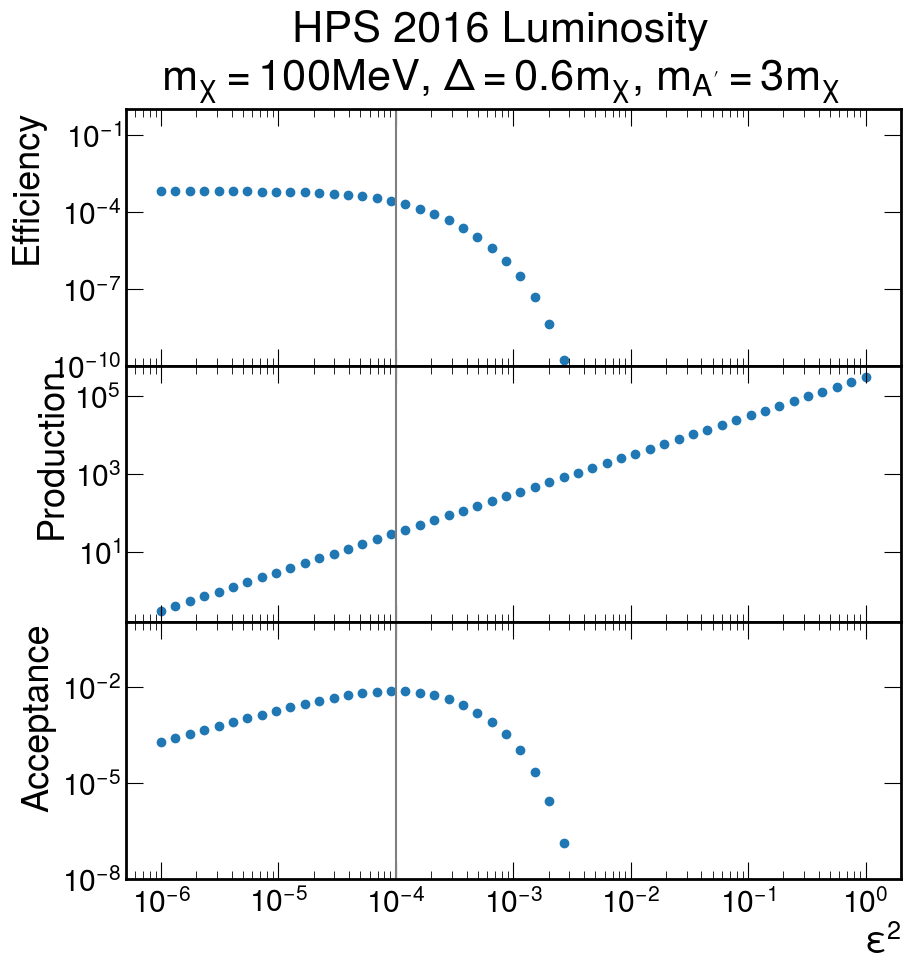

In [11]:
fig, (eff, prod, full) = plt.subplots(
    nrows = 3,
    sharex = 'col',
    gridspec_kw = dict(
        hspace=0
    )
)

for ax in (eff, prod, full):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.axvline(1e-4, color='gray')

eff.scatter(df.eps2, df.full_eff)
eff.set_ylabel('Efficiency')
eff.set_ylim(ymin=1e-10, ymax=1)

prod.scatter(df.eps2, df.prod_rate)
prod.set_ylabel('Production')

full.scatter(df.eps2, df.full_rate)
full.set_ylabel('Acceptance')
full.set_xlabel('$\\epsilon^2$')
full.set_ylim(ymin=1e-8, ymax=1)

fig.suptitle("""HPS 2016 Luminosity
$m_\\chi=100$MeV, $\Delta = 0.6m_\\chi$, $m_{A'}=3m_\\chi$""")
fig.savefig('plots/mchi-100-rdmchi-0.6-rmap-3-acc-rate.pdf', bbox_inches='tight')
plt.show()

# Signal Scan

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import uproot
import awkward as ak
import hist

def params_from_path(p: Path):
    params = p.stem.split('_')
    params = {params[i]:params[i+1] for i in range(0,len(params),2)}
    params['filepath'] = p
    return params


lumi = 10.7 # pb^{-1}
inverse_alpha = 137

def radFrac(mass):
    """total radiative fraction polynomial fit to MC distributions

    calculated by Alic Spellman for 2016 SIMPs using KF tracking on 11/15/22
    """
    radF = -1.04206e-01 \
         + 9.92547e-03*mass \
         + -1.99437e-04*pow(mass, 2) \
         + 1.83534e-06*pow(mass, 3) \
         + -7.93138e-9*pow(mass, 4) \
         + 1.30456e-11*pow(mass, 5)
    return radF

def totRadAcc(mass):
    """Total radiative acceptance polynomial fit to MC distributions

    calculated by Alic Spellman for 2016 SIMPs using KF tracking on 11/15/22
    """
    acc = -7.35934e-01 \
        + 9.75402e-02*mass \
        - 5.22599e-03*pow(mass, 2) \
        + 1.47226e-04*pow(mass, 3) \
        - 2.41435e-06*pow(mass, 4) \
        + 2.45015e-08*pow(mass, 5) \
        - 1.56938e-10*pow(mass, 6) \
        + 6.19494e-13*pow(mass, 7) \
        - 1.37780e-15*pow(mass, 8) \
        + 1.32155e-18*pow(mass, 9)
    return acc

def dNdm(mass, binwidth = 30.0):
    value = 0.0
    for name, pack in dNdm.__raw_data.items():
        t = pack['tree']
        value += ak.sum(
            (t['unc_vtx_mass']*1000 > mass - binwidth/2)&(t['unc_vtx_mass']*1000 < mass + binwidth/2)
        )*pack['scale']
    return value/binwidth

dNdm.__raw_data = {
    'tritrig': {
        'file': '../../simp-rate/final_hadd_tritrigv2-beamv6_2500kBunches_HPS-PhysicsRun2016-Pass2_v4_5_0_pairs1_976_KF_CR.root',
        'scale': 1.416e9*lumi/(50000*9853)
    },
    'wab': {
        'file': '../../simp-rate/final_hadd_wabv3-beamv6_2500kBunches_HPS-PhysicsRun2016-Pass2_v4_5_0_pairs1_KF_ana_CR.root',
        'scale': 0.1985e12*lumi/(100000*9966)
    }
}

for name, pack in dNdm.__raw_data.items():
    with uproot.open(pack['file']) as f:
        pack['tree'] = f['vtxana_kf_vertexSelection_Tight_CR/vtxana_kf_vertexSelection_Tight_CR_tree'].arrays()

def darkphoton_production(mass):
    if totRadAcc(mass) > 0:
        return (3*inverse_alpha/2)*np.pi*mass*radFrac(mass)*dNdm(mass)/totRadAcc(mass)
    else:
        return 0

In [74]:
import pandas as pd

def rate(mchi, rdmchi, rmap):
    opts = rate.__lut__[
        (rate.__lut__['mchi']==mchi)
        &(rate.__lut__['rdmchi']==rdmchi)
        &(rate.__lut__['rmap']==rmap)
    ]
    if len(opts) == 0:
        raise ValueError(f'No width calculated for {(mchi, rdmchi, rmap)}.')
    return opts.chi2_width_per_epsilon.mean()

rate.__lut__ = pd.concat([pd.read_csv('umn-signal-width.csv'), pd.read_csv('umn-signal-dense-width.csv')])

from scipy.interpolate import CubicSpline
rate.__spline__ = CubicSpline(
    [30, 50, 70, 110, 130],
    [7.127e-17, 1.203e-16, 1.688e-16, 2.663e-16, 3.14e-16]
)
rate.__gen_epsilon_sq__ = 1e-6

def ctau(rate):
    c = 3.00e10  # cm/s
    hbar = 6.58e-25  # GeV*sec
    return c*hbar/rate

def weight_by_z(z, gamma_c_tau):
    return np.exp((-4.3 - z)/gamma_c_tau)/gamma_c_tau

def load_signal(fp: Path):
    plist = fp.stem.split('_')[:-1]
    params = {plist[i]:plist[i+1] for i in range(0,len(plist),2)}
    for k in ['mchi','rmap','rdmchi']:
        params[k] = float(params[k])
    params['nruns'] = int(params['nruns'])
    nevents = params['nevents']
    if nevents[-1] == 'k':
        nevents = 1000*int(nevents[:-1])
    elif nevents[-1] == 'M':
        nevents = 1000000*int(nevents[:-1])
    else:
        nevents = int(nevents)
    params['nevents'] = nevents
    params['chi2_width_per_eps2'] = rate(params['mchi'], params['rdmchi'], params['rmap'])
    params['ap_prod_rate_per_eps2'] = darkphoton_production(params['rmap']*params['mchi'])
    return params, load.FromROOT.hps_reco()(fp)

In [155]:
from typing import MutableMapping

def to_accumulator(df: pd.DataFrame):
    """convert a DataFrame into a dict of accumulatable columns"""
    return {
        column : mfsa.accumulator.column_accumulator(df[column].to_numpy())
        for column in df.columns
    }


def from_accumulator(df: MutableMapping[str, mfsa.accumulator.column_accumulator]):
    return pd.DataFrame({
        column : accumulator.value
        for column, accumulator in df.items()
    })


def safe_divide(numerator: np.array, denominator: np.array, *, fill_value=np.nan):
    if isinstance(denominator, ak.Array):
        denominator = denominator.to_numpy()
    if isinstance(numerator, ak.Array):
        numerator = numerator.to_numpy()
    result = np.full(len(denominator), fill_value, dtype=denominator.dtype)
    result[denominator > 0] = numerator[denominator > 0] / denominator[denominator > 0]
    return result


def process_signal(args):
    params, events = args
    df = pd.DataFrame({
        'eps2' : np.logspace(-2, -6)
    })
    df['ctau'] = ctau(params['chi2_width_per_eps2']*df.eps2)
    event_sel = (
        ak.count(events.vertex.chi2, axis=1)==1
    )
    chi2 = ak.flatten(events[event_sel].mc_particle[events[event_sel].mc_particle.pdg==1000023])
    vtx = ak.flatten(events[event_sel].vertex)

    vtx_sel = (
        (vtx.electron.track.time < 10)
        &(vtx.positron.track.time < 10)
        &(vtx.electron.goodness_pid < 10)
        &(vtx.positron.goodness_pid < 10)
        &(abs(vtx.electron.track.time - (vtx.electron.cluster.time - 43.0)) < 4)
        &(abs(vtx.positron.track.time - (vtx.positron.cluster.time - 43.0)) < 4)
        &(abs(vtx.electron.cluster.time - vtx.positron.cluster.time) < 1.45)
        &(safe_divide(vtx.electron.track.chi2, vtx.electron.track.ndf, fill_value=9000) < 15)
        &(safe_divide(vtx.positron.track.chi2, vtx.positron.track.ndf, fill_value=9000) < 15)
        &(vtx.electron.track.p.mag < 1.750)
        &(vtx.electron.track.p.mag > 0.400)
        &(vtx.positron.track.p.mag > 0.400)
    )

    vtx = vtx[vtx_sel]
    chi2 = chi2[vtx_sel]
    n_trks = ak.count(events[event_sel].track.chi2, axis=1)[vtx_sel]
    
    df['num_pass'] = ak.count(vtx.chi2)
    df['num_thrown'] = params['nevents']*params['nruns']
    def reweight_cut(a_ctau):
        reweights = weight_by_z(chi2.ep.z, chi2.p.energy/chi2.p.mass * a_ctau)
        return ak.sum(reweights), ak.sum(reweights[vtx.pos.fZ > 10])
    df[['reweightsum','reweightsum_pass']] = df.apply(lambda row: reweight_cut(row['ctau']), axis=1, result_type='expand')
    df['z_cut_eff'] = df.reweightsum_pass / df.reweightsum
    df['event_selection_eff'] = df.num_pass / df.num_thrown
    df['full_eff'] = df.z_cut_eff * df.event_selection_eff
    df['prod_rate'] = (df.eps2)*params['ap_prod_rate_per_eps2'] # eps=1 value copied from prior table for HPS 2016 Lumi
    df['full_rate'] = df.full_eff*df.prod_rate
    df['mchi'] = params['mchi']
    df['rmap'] = params['rmap']
    df['rdmchi'] = params['rdmchi']

    h = {}
    h['vtx'] = hist.Hist(
        hist.axis.StrCategory(
            ['reco','truth']
        ),
        hist.axis.Regular(
            130,-80,180,
            name = 'vtxz',
            label = 'Vertex Z [mm]'
        )
    )
    h['vtx'].fill('reco', vtx.pos.fZ)
    h['vtx'].fill('truth', chi2.ep.z)

    h['n_trks'] = hist.Hist(
        hist.axis.Regular(
            5,0,5,
            name='n_trks',
            label='Total Num Reco Tracks'
        )
    )
    h['n_trks'].fill(n_trks)
    return { 
        'roacc': to_accumulator(df), 
        (params['mchi'], params['rdmchi'], params['rmap']) : h
    }


def unpack_roacc(out):
    """for simple analyses where one file corresponds to a single parameter point"""
    out['roacc'] = from_accumulator(out['roacc'])

def groupby_signal_params(out):
    """for more complicated analyses where there could be many files for a single parameter point"""
    out['roacc_unmerged'] = from_accumulator(out['roacc'])
    df = out['roacc_unmerged'].groupby(
        ['eps2','mchi','rdmchi','rmap']
    ).agg(
        {
            'num_pass': np.sum,
            'num_thrown': np.sum,
            'reweightsum': np.sum,
            'reweightsum_pass': np.sum,
            'prod_rate': np.mean
        }
    ).reset_index()
    df['z_cut_eff'] = df.reweightsum_pass / df.reweightsum
    df['event_selection_eff'] = df.num_pass / df.num_thrown
    df['full_eff'] = df.z_cut_eff * df.event_selection_eff
    df['full_rate'] = df.full_eff*df.prod_rate
    out['roacc'] = df

In [156]:
out = mfsa.run(
    process_signal, 
    [
        f
        for f in chain(
            Path('/local/cms/user/eichl008/hps/idm/umn-signal/merged').iterdir(),
            Path('/local/cms/user/eichl008/hps/idm/umn-signal-dense/merged').iterdir()
        )
        if f.suffix == '.root' and not f.stem.startswith('sim_')
    ],
    preprocess = load_signal,
    postprocess = groupby_signal_params
)

  0%|          | 0/138 [00:00<?, ?it/s]

In [144]:
out['roacc']

,eps2,mchi,rdmchi,rmap,num_pass,num_thrown,reweightsum,reweightsum_pass,prod_rate,z_cut_eff,event_selection_eff,full_eff,full_rate
0,0.000001,20.0,0.4,2.4,582,2000000,0.012730,0.000000e+00,71338.898422,0.000000e+00,0.000291,0.000000e+00,0.000000e+00
1,0.000001,20.0,0.4,2.5,745,2000000,0.014397,0.000000e+00,64722.858302,0.000000e+00,0.000373,0.000000e+00,0.000000e+00
2,0.000001,20.0,0.4,2.6,963,2000000,0.016623,0.000000e+00,59588.043902,0.000000e+00,0.000481,0.000000e+00,0.000000e+00
3,0.000001,20.0,0.4,3.0,1550,2000000,0.016305,8.541668e-06,44640.219559,5.238639e-04,0.000775,4.059945e-07,1.812369e-02
4,0.000001,20.0,0.5,2.4,1228,2000000,0.075172,0.000000e+00,71338.898422,0.000000e+00,0.000614,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295,0.010000,130.0,0.5,2.5,604,2000000,0.187166,0.000000e+00,670.345721,0.000000e+00,0.000302,0.000000e+00,0.000000e+00
6296,0.010000,130.0,0.5,3.0,495,2000000,5.379975,1.111840e-130,26.808084,2.066627e-131,0.000247,5.114901e-135,1.371207e-133
6297,0.010000,130.0,0.6,2.0,1838,2000000,11.973880,0.000000e+00,18315.739218,0.000000e+00,0.000919,0.000000e+00,0.000000e+00
6298,0.010000,130.0,0.6,2.5,1527,1990000,0.027478,0.000000e+00,670.345721,0.000000e+00,0.000767,0.000000e+00,0.000000e+00


/export/scratch/ipykernel_13763/811759143.py:34: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  prod.scatter(sl.eps2, sl.prod_rate)


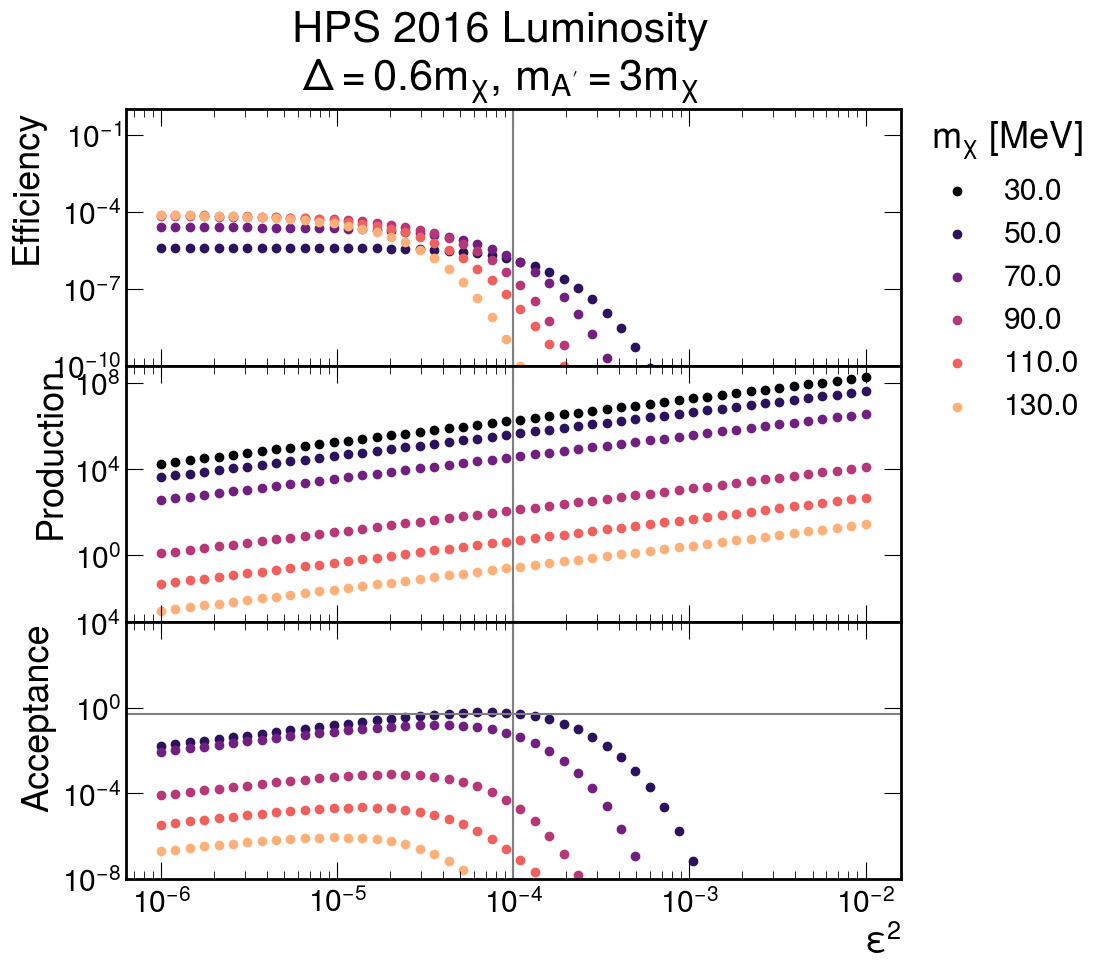

In [49]:
fig, (eff, prod, full) = plt.subplots(
    nrows = 3,
    sharex = 'col',
    gridspec_kw = dict(
        hspace=0,
    )
)

mchi = np.unique(out['roacc'].mchi)

cm = plt.get_cmap('magma')
colors =[cm(1.*i/len(mchi)) for i in range(len(mchi))]

for ax in (eff, prod, full):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.axvline(1e-4, color='gray')
    ax.set_prop_cycle(color=colors)

full.axhline(0.5, color='gray')

for mchi in mchi:
    sl = out['roacc'][(
        (out['roacc'].mchi==mchi)
        &(out['roacc'].rdmchi==0.6)
        &(out['roacc'].rmap==3.0)
    )]

    eff.scatter(sl.eps2, sl.full_eff, label=mchi)
    eff.set_ylabel('Efficiency')
    if sum(sl.full_eff > 0) > 0:
        eff.set_ylim(ymin=1e-10, ymax=1)

    prod.scatter(sl.eps2, sl.prod_rate)
    prod.set_ylabel('Production')

    full.scatter(sl.eps2, sl.full_rate)
    full.set_ylabel('Acceptance')
    full.set_xlabel('$\\epsilon^2$')
    if sum(sl.full_rate > 0) > 0:
        full.set_ylim(ymin=1e-8, ymax=1e4)

fig.legend(
    loc='upper left',
    bbox_to_anchor=(0.9,0.9),
    title='$m_\\chi$ [MeV]'
)
fig.suptitle("""HPS 2016 Luminosity
$\Delta = 0.6m_\\chi$, $m_{A'}=3m_\\chi$""")
#fig.savefig('plots/mchi-100-rdmchi-0.6-rmap-3-acc-rate.pdf', bbox_inches='tight')
plt.show()

2.0 0.4
2.0 0.5
2.0 0.6
2.4 0.4
2.4 0.5
2.4 0.6
2.5 0.4
2.5 0.5
2.5 0.6
2.6 0.4
2.6 0.5
2.6 0.6
3.0 0.4
3.0 0.5
3.0 0.6


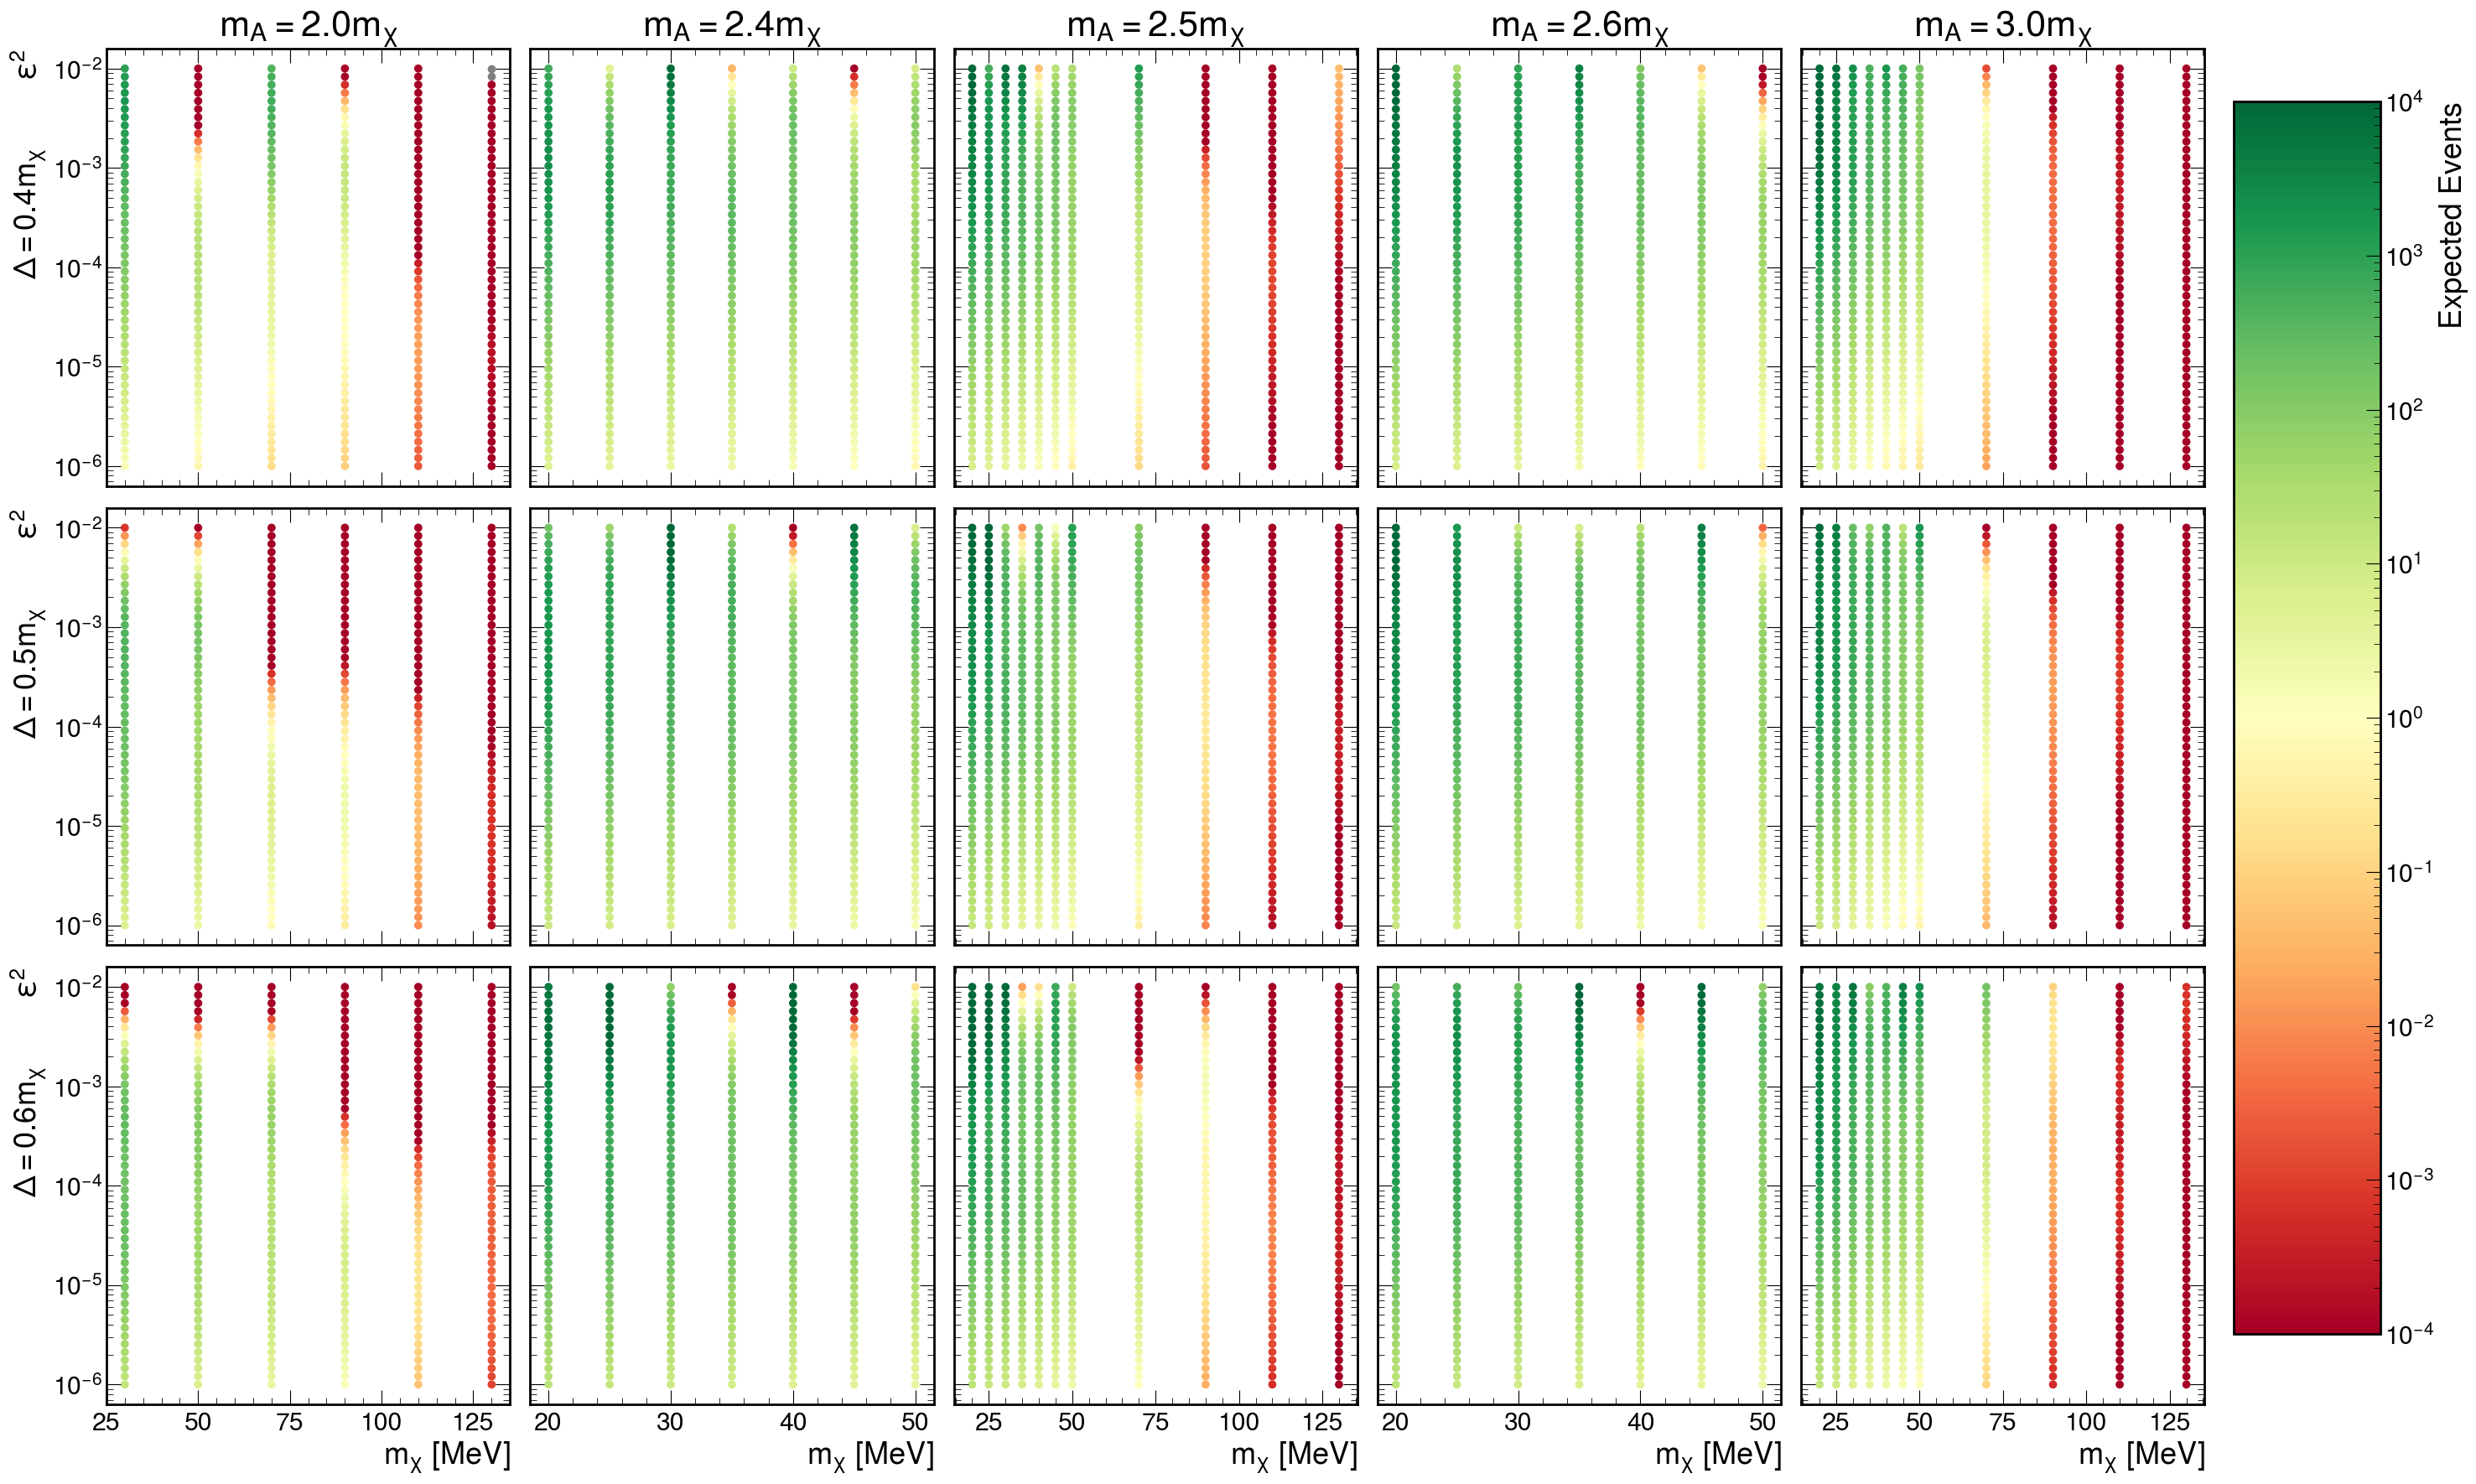

In [161]:
rmaps = np.unique(out['roacc'].rmap)
rdmchis = np.unique(out['roacc'].rdmchi)

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

for rmap, rdmchi in cartesian_product(rmaps, rdmchis):
    print(rmap, rdmchi)

fig, axes = plt.subplots(
    nrows=len(rdmchis),
    ncols=len(rmaps),
    sharex = 'col',
    sharey = 'row',
    figsize = (7*len(rmaps),7*len(rdmchis)),
    gridspec_kw = dict(
        wspace = 0.05,
        hspace = 0.05
    )
)

for (rdmchi, rmap), ax in zip(
    cartesian_product(rdmchis, rmaps),
    axes.flatten()
):
    sl = out['roacc'][(
        (out['roacc'].rdmchi==rdmchi)
        &(out['roacc'].rmap==rmap)
    )]
    ax.scatter(sl.mchi[sl.full_rate==0.0], sl.eps2[sl.full_rate==0.0],
               color='gray')
    im = ax.scatter(sl.mchi, sl.eps2, c=sl.full_rate,
                    norm=mpl.colors.LogNorm(1e-4, 1e4),
                    cmap='RdYlGn')
    ax.set_yscale('log')

for rmap, ax in zip(rmaps, axes[0]):
    ax.set_title(f'$m_A = {rmap}m_\\chi$')

for irow, rdmchi in enumerate(rdmchis):
    axes[irow][0].set_ylabel(f'$\Delta = {rdmchi}m_\\chi$        $\epsilon^2$')
    
for ax in axes[2]:
    ax.set_xlabel('$m_\\chi$ [MeV]')

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Expected Events')
fig.savefig('plots/idm-reach-survey.pdf', bbox_inches='tight')
plt.show()

In [158]:
rate_maxima = out['roacc'].groupby(['rdmchi','rmap','mchi']).full_rate.max().reset_index()

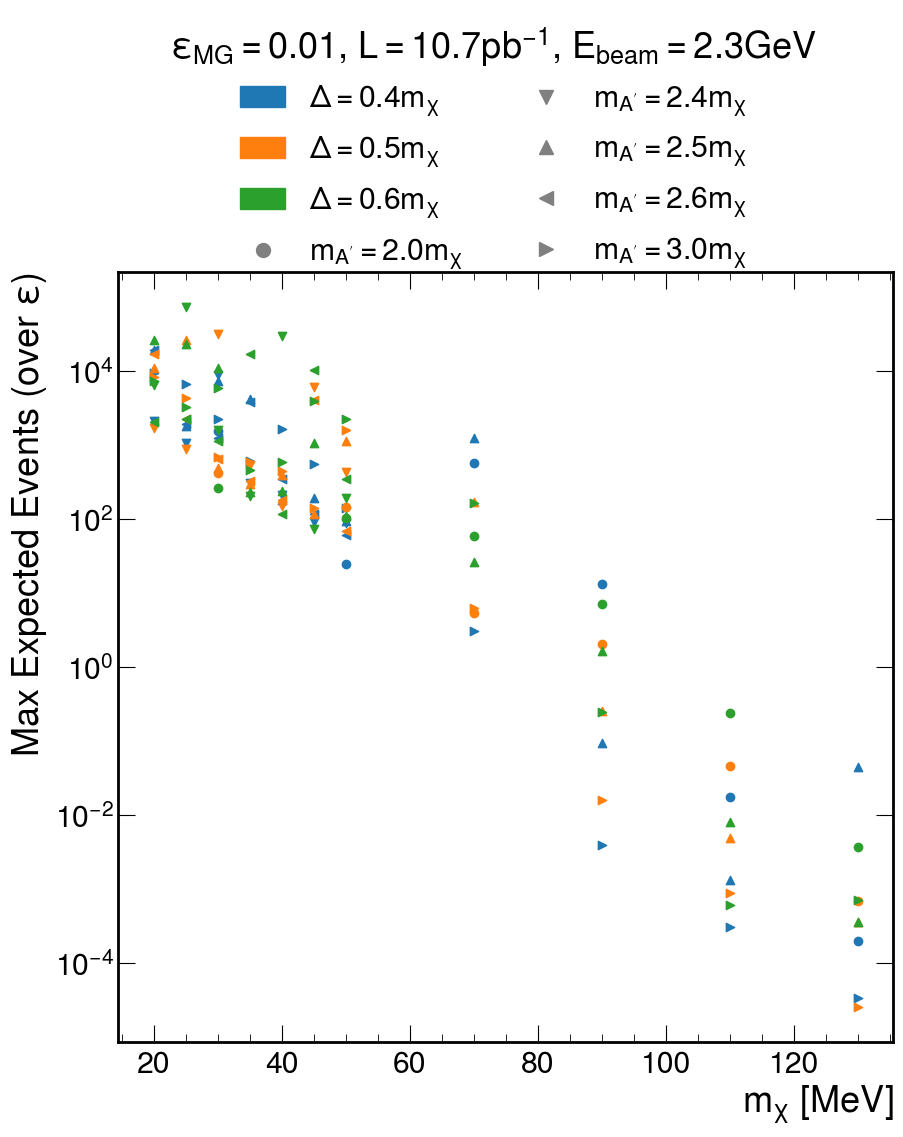

In [159]:
rdmchi = list(np.unique(rate_maxima.rdmchi))
rdmchi.sort()
colors = { r : c for r,c in zip(rdmchi, list(mpl.colors.TABLEAU_COLORS.keys())[:len(rdmchi)])}

rmaps = list(np.unique(rate_maxima.rmap))
rmaps.sort()
markers = { r : m for r, m in zip(rmaps, mpl.lines.Line2D.filled_markers[1:len(rmaps)+1]) }

# fig, axes = plt.subplots(
#     nrows = 2,
#     sharex = True,
#     gridspec_kw = dict(
#         hspace = 0,
#         bottom=0, top=1, left=0, right=1
#     )
# )
fig, ax = plt.subplots()

for rdmchi, color in colors.items():
    for rmap, marker in markers.items():
        sl=rate_maxima[(rate_maxima.rdmchi==rdmchi)&(rate_maxima.rmap==rmap)]
        if sum(sl.full_rate) == 0:
            continue
        ax.scatter(sl.mchi, sl.full_rate,
            color = color,
            marker = marker
        )
ax.set_yscale('log')

legend_artists = []
for rdmchi, color in colors.items():
    legend_artists.append(
        mpl.patches.Patch(
            facecolor=color, edgecolor=color, 
            label=f'$\\Delta = {rdmchi}m_\\chi$'
        )
    )
for rmap, marker in markers.items():
    legend_artists.append(
        mpl.lines.Line2D(
            [0],[0],
            marker = marker, color='gray', lw=0,
            markersize=10,
            label=f'$m_{{A\'}}={rmap}m_\\chi$'
        )
    )

fig.legend(
    title='$\\epsilon_\\mathrm{MG}=0.01$, $\\mathcal{L}=10.7\\mathrm{pb}^{-1}$, $E_\\mathrm{beam}=2.3$GeV',
    handles=legend_artists,
    ncols=2,
    loc='lower center',
    bbox_to_anchor=(0.5,0.85)
)

ax.set_xlabel('$m_\\chi$ [MeV]')
ax.set_ylabel('Max Expected Events (over $\\epsilon$)')
fig.savefig('plots/maximum-reach.pdf', bbox_inches='tight')
plt.show()

In [119]:
rate_maxima[(rate_maxima.mchi==30)&(rate_maxima.rdmchi==0.5)&(rate_maxima.rmap==2.5)].full_rate.iloc[0]

7.299856377442937

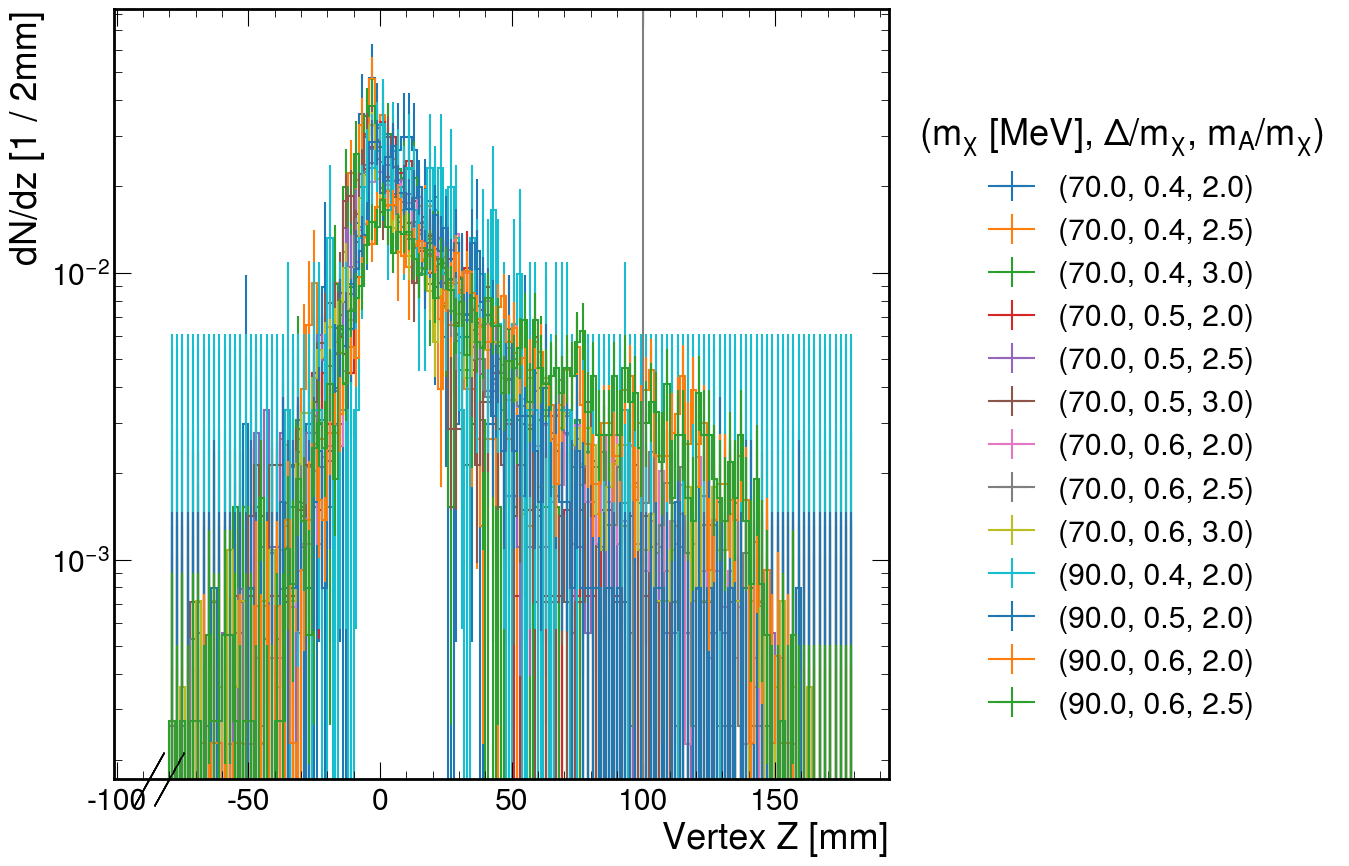

In [162]:
fig, ax = plt.subplots()
# ax.set_prop_cycle(
#     color=colors,
# )

vtx_h = [
    (key, val['vtx'])
    for key, val in out.items()
    if isinstance(key, tuple)
]
vtx_h.sort(key = lambda entry : entry[0])

for (mchi, rdmchi, rmap), h in vtx_h:
    if rate_maxima[(rate_maxima.mchi==mchi)&(rate_maxima.rdmchi==rdmchi)&(rate_maxima.rmap==rmap)].full_rate.iloc[0] > 1.0 and mchi > 50:
        h['reco',:].plot(label=f'{(mchi,rdmchi,rmap)}', density=True)
plt.axvline(100, color='gray')
plt.legend(
    title='($m_\\chi$ [MeV], $\Delta/m_\\chi$, $m_{A}/m_\\chi$)',
    loc='upper left',
    bbox_to_anchor=(1.,0.9)
)
plt.ylabel('dN/dz [1 / 2mm]')
plt.yscale('log')
plt.savefig('plots/max-reach-over-1-vtx-z.pdf', bbox_inches='tight')
plt.show()

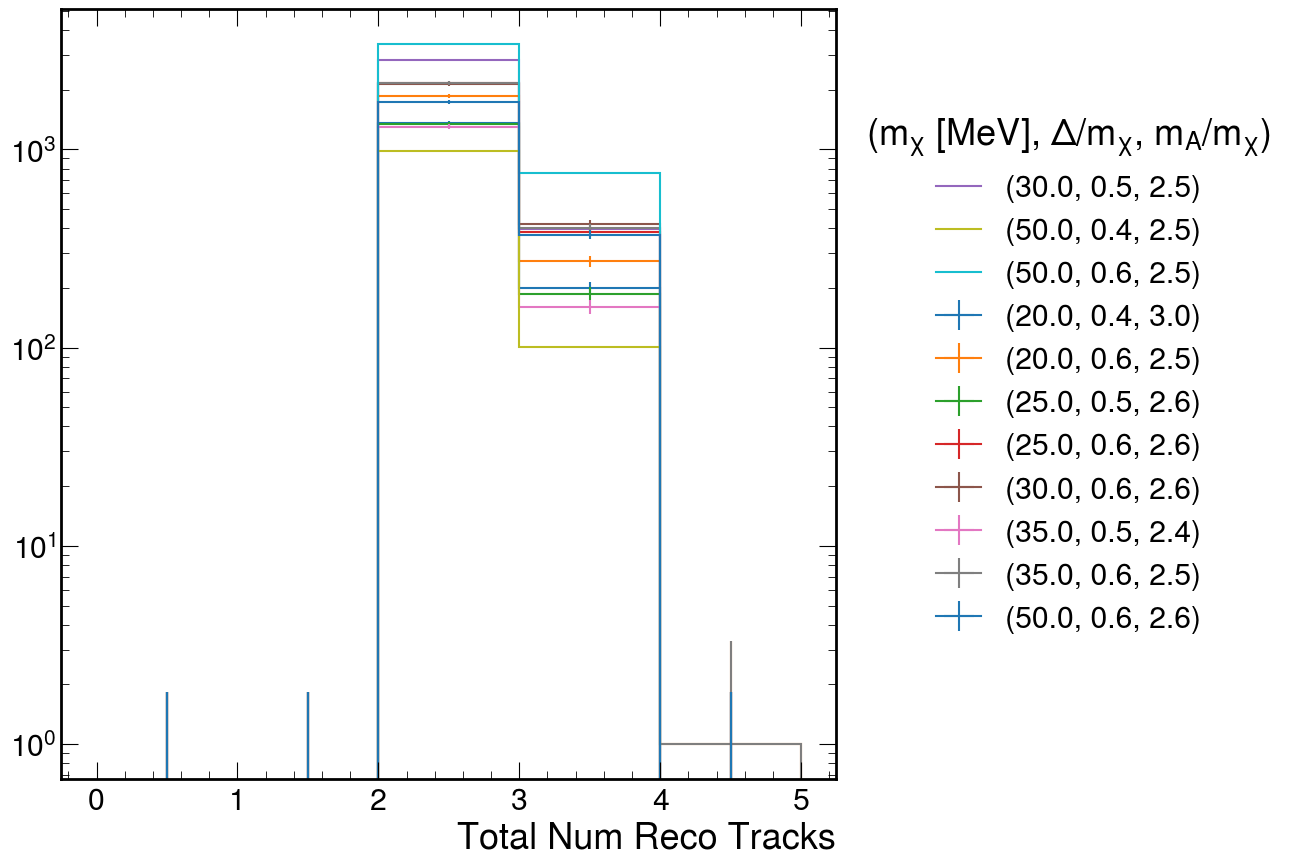

In [154]:
fig, ax = plt.subplots()
# ax.set_prop_cycle(
#     color=colors,
# )

ntracks = [
    (key, val['n_trks'])
    for key, val in out.items()
    if isinstance(key, tuple)
]
ntracks.sort(key = lambda entry : entry[0])

for (mchi, rdmchi, rmap), h in ntracks:
    if rate_maxima[(rate_maxima.mchi==mchi)&(rate_maxima.rdmchi==rdmchi)&(rate_maxima.rmap==rmap)].full_rate.iloc[0] > 1.0:
        h.plot(label=f'{(mchi,rdmchi,rmap)}')
plt.legend(
    title='($m_\\chi$ [MeV], $\Delta/m_\\chi$, $m_{A}/m_\\chi$)',
    loc='upper left',
    bbox_to_anchor=(1.,0.9)
)
plt.yscale('log')
plt.savefig('plots/max-reach-over-1-n-tracks.pdf',bbox_inches='tight')
plt.show()

# Standard Bkgd

In [169]:
test_tritrig = '/local/cms/user/eichl008/hps/idm/bkgd/tritrig/tuples/tritrig-beam_nruns_200_startrun_5139.root'
test_wab = '/local/cms/user/eichl008/hps/idm/bkgd/wab/tuples/wab-beam_nruns_2000_startrun_1.root'

In [166]:
def load_bkgd(fp: Path):
    plist = fp.stem.split('_')[:-1]
    params = {plist[i]:plist[i+1] for i in range(1,len(plist)-1,2)}
    params['name'] = plist[0]
    params['nruns'] = int(params['nruns'])
    return params, load.FromROOT.hps_reco()(fp)


def process_bkgd(args):
    params, events = args
    event_sel = (
        ak.count(events.vertex.chi2, axis=1)==1
    )
    vtx = ak.flatten(events[event_sel].vertex)

    vtx_sel = (
        (vtx.electron.track.time < 10)
        &(vtx.positron.track.time < 10)
        &(vtx.electron.goodness_pid < 10)
        &(vtx.positron.goodness_pid < 10)
        &(abs(vtx.electron.track.time - (vtx.electron.cluster.time - 43.0)) < 4)
        &(abs(vtx.positron.track.time - (vtx.positron.cluster.time - 43.0)) < 4)
        &(abs(vtx.electron.cluster.time - vtx.positron.cluster.time) < 1.45)
        &(safe_divide(vtx.electron.track.chi2, vtx.electron.track.ndf, fill_value=9000) < 15)
        &(safe_divide(vtx.positron.track.chi2, vtx.positron.track.ndf, fill_value=9000) < 15)
        &(vtx.electron.track.p.mag < 1.750)
        &(vtx.electron.track.p.mag > 0.400)
        &(vtx.positron.track.p.mag > 0.400)
    )

    vtx = vtx[vtx_sel]
    n_trks = ak.count(events[event_sel].track.chi2, axis=1)[vtx_sel]

    h = {}
    h['vtx'] = hist.Hist(
        hist.axis.Regular(
            130,-80,180,
            name = 'vtxz',
            label = 'Vertex Z [mm]'
        )
    )
    h['vtx'].fill(vtx.pos.fZ)

    h['n_trks'] = hist.Hist(
        hist.axis.Regular(
            5,0,5,
            name='n_trks',
            label='Total Num Reco Tracks'
        )
    )
    h['n_trks'].fill(n_trks)
    return { 
        params['name'] : h
    }

In [ ]:
bkgd = mfsa.run(
    process_bkgd, 
    [
        f
        for f in chain(
            Path('/local/cms/user/eichl008/hps/idm/bkgd/wab/tuples').iterdir(),
            Path('/local/cms/user/eichl008/hps/idm/bkgd/tritrig/tuples').iterdir()
        )
        if f.suffix == '.root'
    ],
    preprocess = load_bkgd,
)

  0%|          | 0/54 [00:00<?, ?it/s]

In [ ]:
bkgd